<a href="https://colab.research.google.com/github/msrepo/ml-mscise-2023/blob/master/deep_learning/examples/Batch_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original notebook: Probabilistic Machine Learning, Kevin Murphy

[Original github repo](https://github.com/probml)

Implementation of batchnorm layer from scratch and added to LeNet CNN

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms

from IPython import display 
import random
import os
import time

np.random.seed(seed=1)
torch.manual_seed(1)
!mkdir /content/figures

mkdir: cannot create directory ‘/content/figures’: File exists


### Implementation from scratch

For fully connected layers, we take the average along minibatch samples for each dimension independently. For 2d convolutional layers, we take the average along minibatch samples, and along horizontal and vertical locations, for each channel independently.

When training, we update the estimate of the mean and variance using a moving average. When testing, we use the pre-computed values.

In [3]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
  # use is_grad_enabled to determine whether the current mode is training or inference mode
  if not torch.is_grad_enabled():
    # if inference mode, use the mean and variance obtained by moving average
    X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
  else:
    assert len(X.shape) in (2,4)
    # this is a fully connected layer
    if len(X.shape) == 2:
      mean = X.mean(dim=0)
      var = ((X - mean) ** 2).mean(dim=0)
    else:
      # when using 2D convolutoinal layer, calculate mean and variance
      # on the channel dim (axis=1). Here we need to maintain the shape of 'X', so that the broadcasting 
      # operation can be carried out later
      mean = X.mean(dim=(0,2,3),keepdim=True)
      var = ((X - mean)** 2).mean(dim=(0,2,3),keepdim=True)
    # In training mode, the current mean and variance are used for standardization
    X_hat = (X - mean) / torch.sqrt(var + eps)
    # update the mean and variance using moving average
    moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
    moving_var = momentum * moving_var + (1.0 - momentum) * var
  Y = gamma * X_hat + beta # scale and shift
  return Y, moving_mean.data, moving_var.data

### Wrap the batch norm function in a layer

In [4]:
class BatchNorm(nn.Module):
  # 'num_features' : the number of outputs for a fully-connected layer
  # or the number of output channels for a convolutional layer.
  # 'num_dims' : 2 for a fully-connected layer and 4 for a convolutional layer
  def __init__(self, num_features, num_dims):
    super().__init__()
    if num_dims == 2:
      shape = (1, num_features)
    else:
      shape = (1, num_features, 1, 1)
    # The scale parameter and the shift parameter (model parameters) are 
    # initialized to 1 and 0, respectively
    self.gamma = nn.Parameter(torch.ones(shape))
    self.beta = nn.Parameter(torch.zeros(shape))
    
    self.moving_mean = torch.zeros(shape)
    self.moving_var = torch.ones(shape)
  
  def forward(self, X):
    # If X is not on the main memory, copy moving_mean and 
    # moving_var to the device where X is located
    if self.moving_mean.device != X.device:
      self.moving_mean = self.moving_mean.to(X.device)
      self.moving_var = self.moving_var.to(X.device)
    # save the update moving_mean and moving_var
    Y, self.moving_mean, self.moving_var = batch_norm(
        X, self.gamma, self.beta, self.moving_mean, self.moving_var, eps=1e-5, momentum=0.9
    )
    return Y

### Applying batch norm to LeNet

We add BN layers after some of the convolutions and fully connected layers, but before the activation functions

In [6]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5),
    BatchNorm(6, num_dims=4),
    nn.Sigmoid(),

    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(6, 16, kernel_size=5),
    BatchNorm(16, num_dims=4),
    nn.Sigmoid(),

    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(16 * 4 * 4, 120),
    BatchNorm(120, num_dims=2),
    nn.Sigmoid(),

    nn.Linear(120, 84),
    BatchNorm(84, num_dims=2),
    nn.Sigmoid(),
    nn.Linear(84,10)

)

## Train the model
We can now use larger learning rate as BatchNorm stabilizes training.

In [7]:
def load_data_fashion_mnist(batch_size, resize=None):
  """Download the fashion-mnist dataset and load it into memory"""
  trans = [transforms.ToTensor()]
  if resize:
    trans.insert(0, transforms.Resize(resize))
  trans = transforms.Compose(trans)
  mnist_train = torchvision.datasets.FashionMNIST(root="/content/data",train=True, transform=trans, download=True)
  mnist_test = torchvision.datasets.FashionMNIST(root="/content/data",train=False, transform=trans, download=True)
  return (
      data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=4),
      data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=4)
  )

In [10]:
class Animator:
  """For plotting data in animation"""
  def __init__(
      self,
      xlabel=None,
      ylabel=None,
      legend=None,
      xlim=None,
      ylim=None,
      xscale='linear',
      yscale='linear',
      fmts=('-','m--','g-.','r:'),
      nrows=1,
      ncols=1,
      figsize=(3.5, 2.5)
  ):
    # incrementally plot multiple lines
    if legend is None:
      legend = []
    display.set_matplotlib_formats('svg')
    self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
    if nrows*ncols == 1:
      self.axes = [
          self.axes,
      ]
    # use a lambda function to capture arguments
    self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    self.X, self.Y, self.fmts = None, None, fmts
  
  def add(self, x, y):
    # add multiple data points into the figure
    if not hasattr(y, "__len__"):
      y = [y]
    n = len(y)
    if not hasattr(x, "__len__"):
      x = [x] * n
    if not self.X:
      self.X = [[] for _ in range(n)]
    if not self.Y:
      self.Y = [[] for _ in range(n)]
    for i, (a, b) in enumerate(zip(x,y)):
      if a is not None and b is not None:
        self.X[i].append(a)
        self.Y[i].append(b)
      self.axes[0].cla()
      for x, y, fmt in zip(self.X, self.Y, self.fmts):
        self.axes[0].plot(x, y, fmt)
      self.config_axes()
      display.display(self.fig)
      display.clear_output(wait=True)

In [22]:
class Accumulator:
  def __init__(self, n):
    self.data = [0.0] * n
  
  def add(self, *args):
    self.data = [a + float(b) for a,b in zip(self.data, args)]
  
  def reset(self):
    self.data = [0.0] * len(self.data)
  
  def __getitem__(self, idx):
    return self.data[idx]

In [23]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
  """ Set the axes for matplotlib"""
  axes.set_xlabel(xlabel)
  axes.set_ylabel(ylabel)
  axes.set_xscale(xscale)
  axes.set_yscale(yscale)
  axes.set_xlim(xlim)
  axes.set_ylim(ylim)
  if legend:
    axes.legend(legend)
  axes.grid()

In [24]:
def accuracy(y_hat, y):
  if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
    y_hat = torch.argmax(y_hat, axis=1)
  cmp_ = y_hat.type(y.dtype) == y
  return float(cmp_.type(y.dtype).sum())

def evaluate_accuracy(net, data_iter, device=None):
  if isinstance(net, torch.nn.Module):
    net.eval() # set the model to evaluation mode
    if not device:
      device = next(iter(net.parameters())).device
    net.to(device)
  metric = Accumulator(2)
  for X, y in data_iter:
    X = X.to(device)
    y = y.to(device)
    metric.add(accuracy(net(X), y), y.numel())
  return metric[0] / metric[1]

In [27]:
def train(net, train_iter, test_iter, num_epochs, lr, device):
  num_batches = len(train_iter)
  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      nn.init.xavier_uniform_(m.weight)
    
  net.apply(init_weights)
  

  print(f'training on {device}')
  net.to(device)

  optimizer = torch.optim.SGD(net.parameters(), lr=lr)
  loss = nn.CrossEntropyLoss()

  animator = Animator(xlabel="epoch", xlim=[1, num_epochs], legend=['train_loss', 'train_acc', 'test_loss', 'test_acc'])

  for epoch in range(num_epochs):
    metric = Accumulator(3)
    net.train()
    for i, (X, y) in enumerate(train_iter):
      optimizer.zero_grad()
      X, y = X.to(device), y.to(device)
      y_hat = net(X)
      l = loss(y_hat, y)
      l.backward()
      optimizer.step()
      with torch.no_grad():
        metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
      train_l = metric[0] / metric[2]
      train_acc = metric[1] / metric[2]

      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        animator.add(epoch + (i + 1) / num_batches, (train_l, train_acc, None))
    test_acc = evaluate_accuracy(net, test_iter)
    animator.add(epoch + 1, (None, None, test_acc))
  print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, test acc {test_acc:.3f}')



loss 0.244, train acc 0.910, test acc 0.868


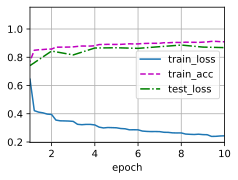

In [28]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)
train(net, train_iter, test_iter, num_epochs, lr, 'cpu')